In [11]:
import matplotlib.pyplot as plt
import kornia
import numpy as np
import scipy
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp2d

In [12]:
def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

In [13]:
def myFlow(img1,img2,len,tau):

    fiveTap = (1/12) * np.array([-1, 8, 0, -8, 1])
    Ix1 = convolve2d(img1, fiveTap.reshape(1, -1), mode='valid')  
    Iy1 = convolve2d(img1, fiveTap.reshape(-1, 1), mode='valid')  

    img1Smoothed = gaussian_filter(img1, 1)
    img2Smoothed = gaussian_filter(img2, 1)

    It1 = convolve2d(img1Smoothed, np.ones((2, 2)), mode='valid') + convolve2d(img2Smoothed, -np.ones((2, 2)), mode='valid')  

    
    u = np.zeros_like(img1)
    v = np.zeros_like(img2)
    flowMap = np.zeros_like(img1,dtype=bool)
    w = int(len / 2)
    for i in range(w, Ix1.shape[0] - w):
        for j in range(w, Ix1.shape[1] - w):
            Ix2 = Ix1[i - w:i + w + 1, j - w:j + w + 1]
            Ix2 = Ix2.flatten()
            Iy2 = Iy1[i - w:i + w + 1, j - w:j + w + 1]
            Iy2 = Iy2.flatten()
            It2 = It1[i - w:i + w + 1, j - w:j + w + 1]
            It2 = It2.flatten()
        
            if Ix2.size == Iy2.size:
                A = np.column_stack((Ix2, Iy2))
                b = -It2
                x = np.linalg.pinv(A).dot(b)
                #we found x ! Ax=b
                u[i, j] = x[0]
                v[i, j] = x[1]
            else:
                u[i, j] = 0
                v[i, j] = 0
            flowMag = np.sqrt(x[0]**2 + x[1]**2)

            if flowMag > tau:
                flowMap[i, j] = 1
            
    return u,v,flowMap
   

In [14]:
def imResized(image):
    imageGray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    imageGray = imageGray/255
    h,w = imageGray.shape[:2]
    h = int(h * 0.5)
    w = int(w * 0.5)
    imageResized = cv2.resize(imageGray,(w,h))
    return imageResized

In [15]:
synth1 = cv2.imread("/cs/home/curtlac/Downloads/synth_0.png")
synth2 = cv2.imread("/cs/home/curtlac/Downloads/synth_1.png")
sphere1 = cv2.imread("/cs/home/curtlac/Downloads/sphere_0.png")
sphere2 = cv2.imread("/cs/home/curtlac/Downloads/sphere_1.png")
coord1 = cv2.imread("/cs/home/curtlac/Downloads/bt_0.png")
coord2 = cv2.imread("/cs/home/curtlac/Downloads/bt_1.png")

synth1G = imResized(synth1)
synth2G = imResized(synth2)
sphere1G = imResized(sphere1)
sphere2G = imResized(sphere2)
coords1G = imResized(coord1)
coords2G = imResized(coord2)


max flow: 1.1425 flow range: u = -1.143 .. 0.860; v = -0.659 .. 0.881



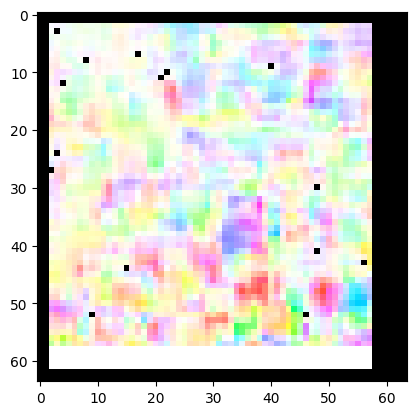

In [16]:
u,v,fmap = myFlow(synth1G,synth2G,4,0.01)
flow = np.dstack((u,v))
plt.imshow(fmap)
colorFlow = flowToColor(flow,verbose=True)
colorFlow[~fmap] = 0
plt.imshow(colorFlow)

max flow: 13.4388 flow range: u = -8.467 .. 2.125; v = -10.707 .. 8.541



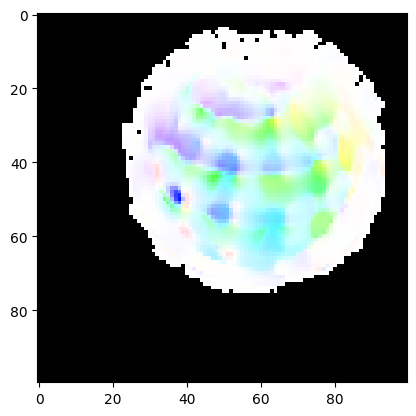

In [17]:
u,v,fmap = myFlow(sphere1G,sphere2G,4,0.01)
flow = np.dstack((u,v))
plt.imshow(fmap)
colorFlow = flowToColor(flow,verbose=True)
colorFlow[~fmap] = 0
plt.imshow(colorFlow)

max flow: 702.6454 flow range: u = -450.116 .. 496.845; v = -453.509 .. 496.845



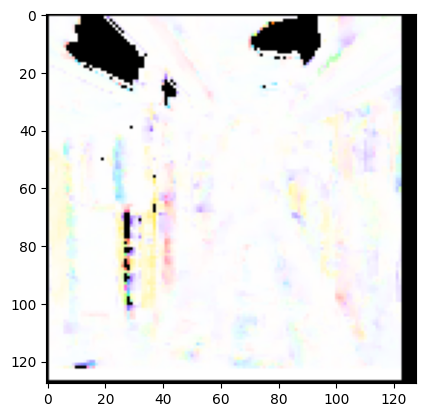

In [18]:
u,v,fmap = myFlow(coords1G,coords2G,2,0.05)
flow = np.dstack((u,v))
plt.imshow(fmap)
colorFlow = flowToColor(flow,verbose=True)
colorFlow[~fmap] = 0
plt.imshow(colorFlow)
#Hi, it seems the window size has a large effect on the boundaries of the image (i could have messed up the code too but whatever
# increasing the window size reduces potenital areas where flow can be found! very cool.

In [21]:
def myWarp(img,u,v):
    m, n = img.shape
    x, y = np.meshgrid(np.arange(1, n + 1), np.arange(1, m + 1))
    xWarped = x + u
    yWarped = y + v
    interp = interp2d(x[0, :], y[:, 0], img, kind='linear', fill_value=0)
    imgWarped = interp(xWarped[0, :], yWarped[:, 0])
    return imgWarped

/tmp/ipykernel_93968/500181614.py:6: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp = interp2d(x[0, :], y[:, 0], img, kind='linear', fill_value=0)
/tmp/ipykernel_93968/500181614.py:7: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In ne

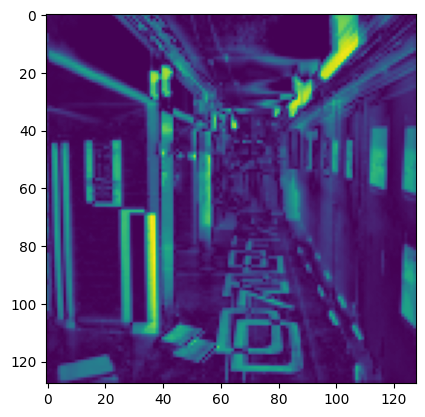

In [22]:
coordsW = myWarp(coords2G,u,v)
diff = np.abs(coords1G - coordsW)
plt.imshow(diff)

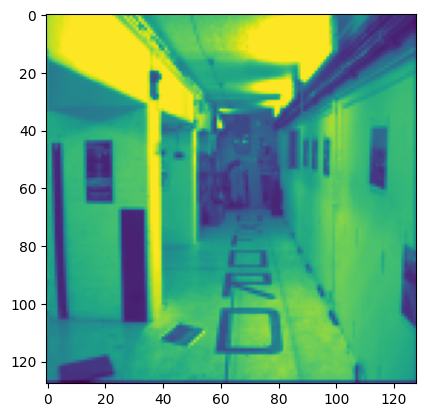

In [23]:
plt.imshow(coords1G)